In [1]:
import socket

print("Hostname: " + socket.gethostname())

Hostname: sx-el-121920


In [2]:
import numpy as np
import torch

%reload_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


## Setup CLIP and open-CLIP

In [3]:
import clip

model, preprocess = clip.load("RN50")
model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [4]:
import open_clip

open_model, _, open_preprocess = open_clip.create_model_and_transforms('RN50', pretrained='openai')
open_model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (

## Check models
Same input results in different output -> Models are the not equal, which is bad/questionable! open-CLIP uses additional layernorm(..) for batchnormalization!

In [5]:
model == open_model

False

## Check preprocessors
Same input results in same output -> Preprocessors are the same, which is good!

In [6]:
preprocess == open_preprocess

False

In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f5bf9cf8dc0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [8]:
open_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f5bf0363c10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Check tokenizers
Same input results in same output -> Tokenizers are the same, which is good!

In [9]:
text_descriptions = ['a photo of the number: "5".',
                     'a photo of the number: "8".',
                     'Hello world!',
                     'My name is Patrick!',
                     'How are you?']

In [10]:
(clip.tokenize(text_descriptions).cuda() == open_clip.tokenize(text_descriptions).cuda()).all()

tensor(True, device='cuda:0')

In [11]:
clip.tokenize

<function clip.clip.tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> Union[torch.IntTensor, torch.LongTensor]>

In [12]:
open_clip.tokenize

<function open_clip.tokenizer.tokenize(texts: Union[str, List[str]], context_length: int = 77) -> torch.LongTensor>

## Compare outputs
Text embeddings are not exactly the same! (Check last digits of the first entry for example!)  
Image embeddings are not exactly the same! (Check last digits of the first entry for example!)  

Findings:  
-> Precision problem: If all parameters are set to float (32-bit) then the embeddings are equal!  
-> Open-CLIP uses 32-bit floats for all parameters.  
-> CLIP uses 16-bit floats in some layers.  
-> This 16/32 bit mix helps to save memory at the cost of some performance

In [13]:
model.encode_text(clip.tokenize(text_descriptions).cuda())

tensor([[ 0.2705,  0.3669,  0.3054,  ..., -0.1647,  0.0877,  0.1377],
        [ 0.0963,  0.2510, -0.0037,  ..., -0.2417,  0.0428,  0.0861],
        [-0.2302,  0.2432, -0.0039,  ...,  0.2419,  0.0048,  0.2634],
        [ 0.0557,  0.4539,  0.0485,  ..., -0.0902, -0.1951,  0.3879],
        [ 0.1184,  0.0610, -0.2788,  ...,  0.1906, -0.1515,  0.0467]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

In [14]:
open_model.encode_text(clip.tokenize(text_descriptions).cuda())

tensor([[ 0.2708,  0.3669,  0.3055,  ..., -0.1659,  0.0883,  0.1383],
        [ 0.0965,  0.2515, -0.0039,  ..., -0.2425,  0.0432,  0.0862],
        [-0.2298,  0.2439, -0.0040,  ...,  0.2421,  0.0041,  0.2641],
        [ 0.0554,  0.4537,  0.0477,  ..., -0.0899, -0.1950,  0.3882],
        [ 0.1180,  0.0595, -0.2785,  ...,  0.1908, -0.1504,  0.0476]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [15]:
import skimage
import os
from PIL import Image

orig_img = Image.open(os.path.join(skimage.data_dir, 'astronaut.png')).convert("RGB")
img = preprocess(orig_img).cuda().unsqueeze(dim=0)
open_img = open_preprocess(orig_img).cuda().unsqueeze(dim=0)

In [16]:
model

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [17]:
for p in model.parameters():
    print(p.data.dtype)

torch.float32
torch.float16
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.float32
torch.float16
torch.float32
torch.

In [18]:
for p in open_model.parameters():
    print(p.data.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

In [19]:
# set CLIP and open-CLIPs precision to the same precision
if False:
    for p in model.parameters(): 
        p.data = p.data.float()
        
    for p in open_model.parameters(): 
        p.data = p.data.float()

In [20]:
model.encode_image(img)

tensor([[ 0.0121, -0.0536,  0.0384,  ..., -0.0398, -0.0492,  0.3120]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SqueezeBackward1>)

In [29]:
open_model.encode_image(open_img)

tensor([[ 0.0121, -0.0536,  0.0384,  ..., -0.0398, -0.0490,  0.3124]],
       device='cuda:0', grad_fn=<SelectBackward0>)

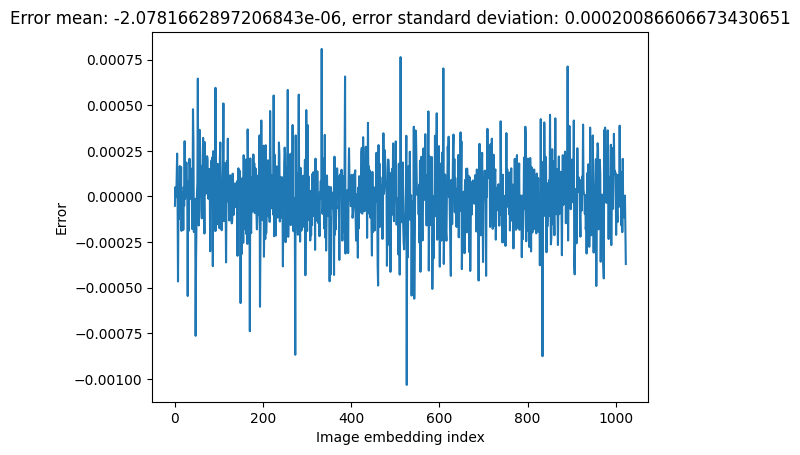

In [28]:
import matplotlib.pyplot as plt

res = (model.encode_image(img).cpu().detach().numpy() - open_model.encode_image(img).cpu().detach().numpy())
plt.plot(np.array(list(range(res.shape[1]))), res.T)
plt.xlabel("Image embedding index")
plt.ylabel("Error")
plt.title(f"Error mean: {res.mean()}, error standard deviation: {res.std()}")
plt.show()

## Summary for Github discussion

tensor([[ 0.0121, -0.0536,  0.0384,  ..., -0.0398, -0.0492,  0.3120]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SqueezeBackward1>)
tensor([[ 0.0121, -0.0536,  0.0384,  ..., -0.0398, -0.0490,  0.3124]],
       device='cuda:0', grad_fn=<SelectBackward0>)


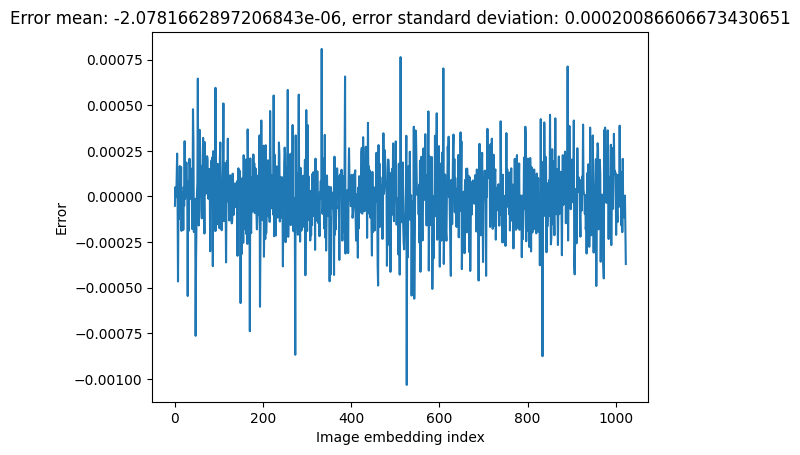

In [40]:
import clip
import open_clip

# Load CLIP and open-CLIP
model, preprocess = clip.load("RN50")
model.cuda()
open_model, _, open_preprocess = open_clip.create_model_and_transforms('RN50', pretrained='openai')
open_model.cuda()
    
import skimage
import os
from PIL import Image

# Load and preprocess image
orig_img = Image.open(os.path.join(skimage.data_dir, 'astronaut.png')).convert("RGB")
img = preprocess(orig_img).cuda().unsqueeze(dim=0)
open_img = open_preprocess(orig_img).cuda().unsqueeze(dim=0)

# set CLIP and open-CLIPs precision to the same precision
if False:
    for p in model.parameters(): 
        p.data = p.data.float()
        
    for p in open_model.parameters(): 
        p.data = p.data.float()

# Print embedding to detect possible differences
print(model.encode_image(img))
print(open_model.encode_image(open_img))

import matplotlib.pyplot as plt

# Plot differences between CLIP and open-CLIP embeddings
res = (model.encode_image(img).cpu().detach().numpy() - open_model.encode_image(img).cpu().detach().numpy())
plt.plot(np.array(list(range(res.shape[1]))), res.T)
plt.xlabel("Image embedding index")
plt.ylabel("Error")
plt.title(f"Error mean: {res.mean()}, error standard deviation: {res.std()}")
plt.show()